In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import platform

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

## 데이터 불러오기

In [3]:
df = pd.read_csv('steel_date.csv')

In [4]:
steel = df.copy()


In [5]:
steel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         720 non-null    int64  
 1   PLATE_NO           720 non-null    object 
 2   ROLLING_DATE       720 non-null    object 
 3   SCALE              720 non-null    object 
 4   SPEC               720 non-null    object 
 5   STEEL_KIND         720 non-null    object 
 6   PT_THK             720 non-null    float64
 7   PT_WDTH            720 non-null    int64  
 8   PT_LTH             720 non-null    int64  
 9   PT_WGT             720 non-null    int64  
 10  FUR_NO             720 non-null    object 
 11  FUR_NO_ROW         720 non-null    int64  
 12  FUR_HZ_TEMP        720 non-null    int64  
 13  FUR_HZ_TIME        720 non-null    int64  
 14  FUR_SZ_TEMP        720 non-null    int64  
 15  FUR_SZ_TIME        720 non-null    int64  
 16  FUR_TIME           720 non

## 데이터 전처리

### 칼럼 소문자로 변환

In [6]:
#모든 칼럼 소문자로 변환

steel.rename(str.lower, axis='columns', inplace=True)

### 고유값이 2개인 칼럼 값 치환

In [7]:
#계산이 용이하도록 고유값이 2개인 SCALE과 HSB칼럼을 0과 1로 치환

steel['scale'] = steel['scale'].replace({'양품':1, '불량':0})
steel['hsb'] = steel['hsb'].replace({'적용':1, '미적용':0})

### 중복하는 칼럼 제거

In [8]:
#값이 정확히 일치하는 두 개의 칼럼이 있어 하나를 제거해주었다.

#'FUR_SZ_TEMP', 'FUR_EXTEMP' 칼럼이 정확히 일치하는지 확인
duplicate = steel[['fur_sz_temp','fur_extemp']].assign(duplicate_lambda=lambda x: (x['fur_sz_temp'] == x['fur_extemp']))

#print(test1.to_string())        #출력해보면 두 칼럼의 모든 항목을 비교하는 표를 확인할 수 있다.
print(duplicate['duplicate_lambda'].unique())      #lamda로 추출한 값에 True만 존재하기 때문에, 정확히 일치함을 확인

steel.drop(columns='fur_extemp', inplace=True)

[ True]


### 고유값 확인

In [9]:
#PLATE_NO는 생산된 철의 중복되지 않은 고유번호임을 알 수 있다.

plt_no_nunique = steel['plate_no'].nunique()
plt_no_count = steel['plate_no'].count()
print('plate_no 고유값은 ' + str(plt_no_nunique) + '개,\n' + 
      '데이터 수는' + str(plt_no_count) + '개 입니다.')

plate_no 고유값은 720개,
데이터 수는720개 입니다.


## 시각화

In [52]:
#데이터프레임 추출
spec_1 = pd.Series(steel['spec'].unique())
spec_2 = pd.DataFrame()

for i in spec_1:
    yes = steel[(steel['spec'] == i) & (steel['scale'] == 1)]['scale'].count()
    no = steel[(steel['spec'] == i) & (steel['scale'] == 0)]['scale'].count()
    spec_2 = pd.concat([spec_2,pd.DataFrame([i, yes, no, yes + no]).T])
    
spec_2.reset_index(drop=True)
spec_2.columns = ['spec','1','0','sum']
spec_2.sort_values(by='sum', ascending=False, inplace=True)

In [ ]:
spec_2.head(3)

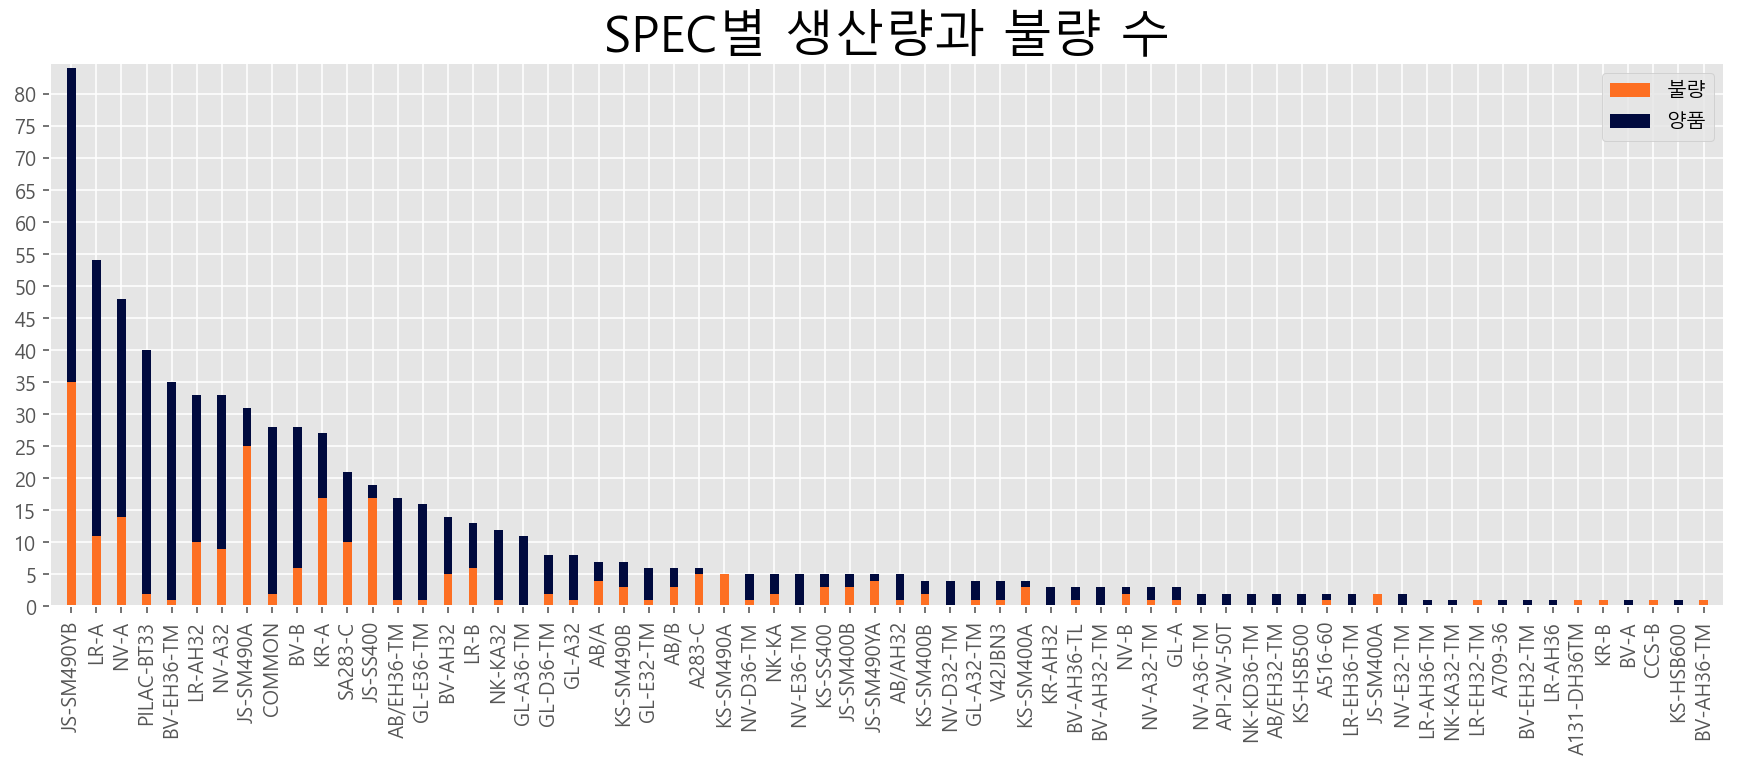

In [53]:
#Stacked Bar 차트

labels = spec_2['spec']
x1 = spec_2['0']
x2 = spec_2['1']
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(15, 5))

ax.bar(labels, x1, width, label='불량', color='#FD6F22')
ax.bar(labels, x2, width, bottom=x1, label='양품', color='#000A3E')
#ax.set_xticklabels(labels, rotation=45)

#ax.set_ylabel('Scores')
ax.set_title('SPEC별 생산량과 불량 수', size=25)
ax.legend()

plt.style.use('ggplot')
#plt.figure(figsize=(15,7))
#plt.bar(bc1_labels, bc1_values, width=0.7)
#plt.set_xlabel(fontsize=10)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 100, step=5))
plt.margins(0.01)
plt.grid(True, axis='y')
plt.show()
fig.savefig("six_project_2.5.1_plot.png", dpi=300)

- 불량율의 기준은 PILAC-BT33 규격을 설정. 5% 미만을 목표로 진행


- 위 그래프 토대로 생산 수 10개 이상의 SPEC을 추려 분석
- 19개의 규격이 전체 생산량의 약 78%를 차지
- 19개에 대한 근거+(파이차트)

#### STEEL_KIND별 불량률 - Stacked bar 차트

In [11]:
#데이터프레임 추출
sk_1 = pd.Series(steel['steel_kind'].unique())
sk_2 = pd.DataFrame()

for i in sk_1:
    yes = steel[(steel['steel_kind'] == i) & (steel['scale'] == 1)]['scale'].count()
    no = steel[(steel['steel_kind'] == i) & (steel['scale'] == 0)]['scale'].count()
    sk_2 = pd.concat([sk_2,pd.DataFrame([i, yes, no, yes + no]).T])
    
sk_2.reset_index(drop=True)
sk_2.columns = ['sk_1','1','0','sum']
sk_2.sort_values(by='sum', ascending=False, inplace=True)

In [12]:
sk_2.head(3)

,sk_1,1,0,sum
0,C0,291,212,503
0,T8,90,5,95
0,T5,41,2,43


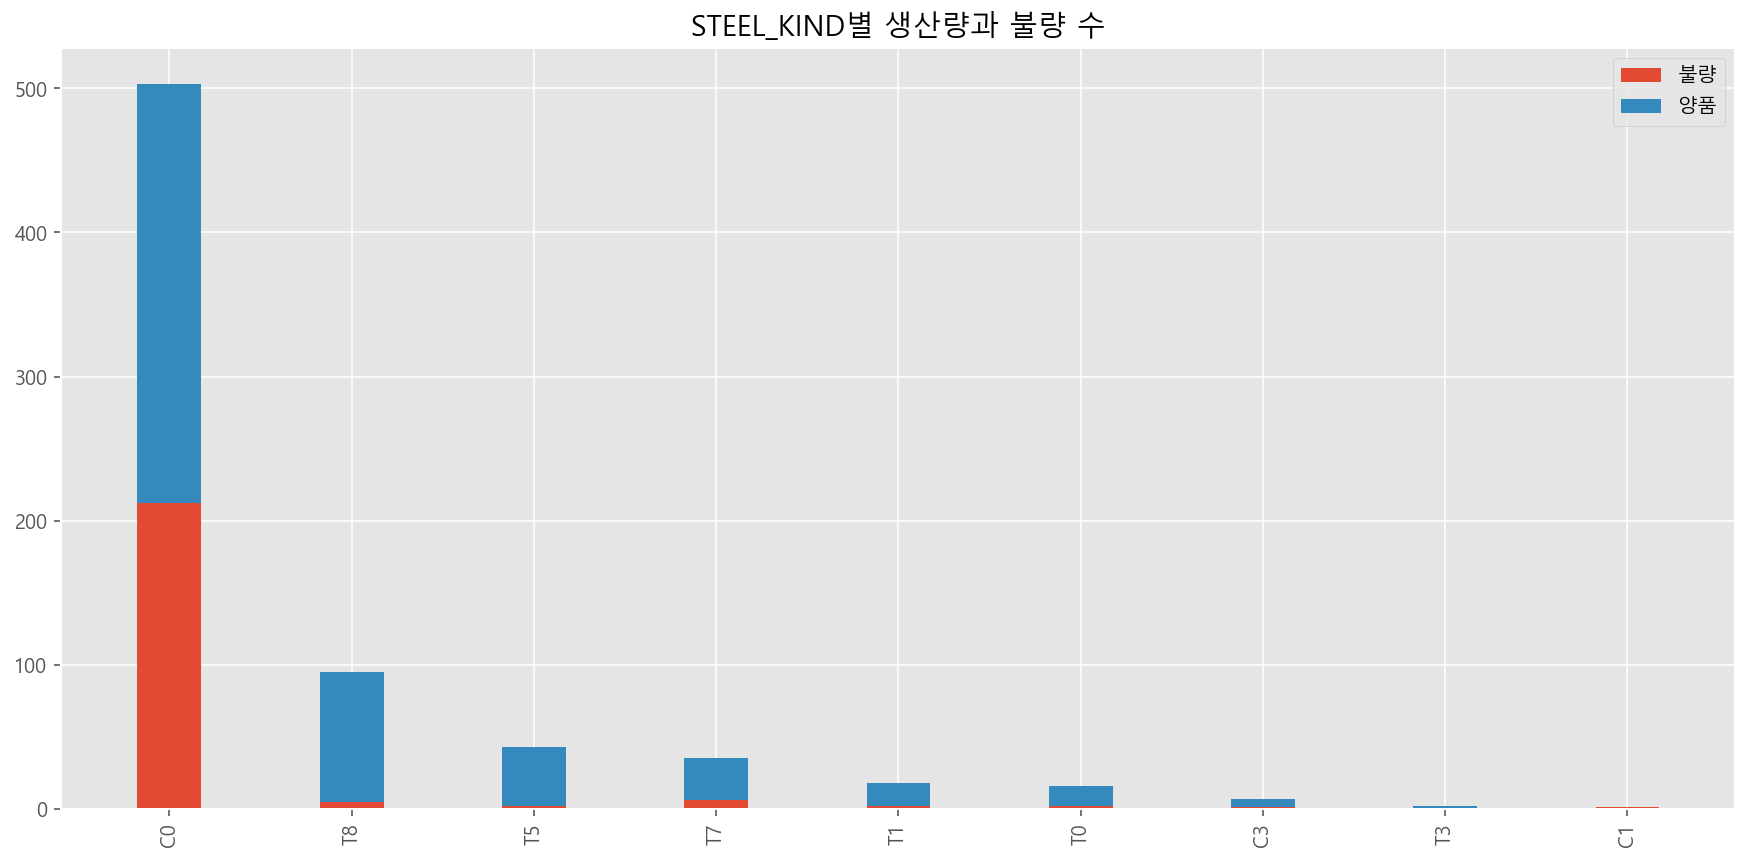

In [14]:
#Stacked Bar 차트

labels = sk_2['sk_1']
x1 = sk_2['0']
x2 = sk_2['1']
width = 0.35

fig, ax = plt.subplots(figsize=(15, 7))

ax.bar(labels, x1, width, label='불량')
ax.bar(labels, x2, width, bottom=x1, label='양품')
ax.set_title('STEEL_KIND별 생산량과 불량 수')
ax.legend()

plt.style.use('ggplot')
plt.xticks(rotation=90)
plt.grid(True, axis='y')
plt.show()

- 위 그래프를 통해 대부분의 불량품은 C0에서 발생하는 것을 파악할 수 있다.
- C0로 만든 제품들을 추리고 그룹을 나눠 분석할 필요가 있음을 알 수 있다.
- C0와 아닌 것들을 묶어서 비교? (막대 or 파이차트)

In [48]:
plt01 = steel.groupby('spec')[['scale']].count()
plt01.sort_values(by='scale', ascending=False, inplace=True)
plt01=plt01.reset_index()
plt01

,spec,scale
0,JS-SM490YB,84
1,LR-A,54
2,NV-A,48
3,PILAC-BT33,40
4,BV-EH36-TM,35
...,...,...
61,CCS-B,1
62,LR-AH36-TM,1
63,LR-AH36,1
64,KR-B,1


In [16]:
pie01 = plt01.iloc[:19, :]
pie02 = plt01.iloc[19:, :]
pie02['scale'].count()

47

In [17]:
pie01['scale'].sum()

564

In [18]:
pie01=pie01.reset_index()

In [19]:
pie01=pie01.append({'spec' : 'etc', 'scale' : 156}, ignore_index=True)


C:\Users\mrshi\AppData\Local\Temp\ipykernel_8340\1037318188.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pie01=pie01.append({'spec' : 'etc', 'scale' : 156}, ignore_index=True)


In [20]:
pie02=pie02.reset_index()

In [50]:
import plotly.graph_objects as go
fig = px.pie(pie01, values='scale', names='spec')
colors = ['#000A3E', '#030F4A', '#071351', '#0B1859', '#0F1D61', '#122064', '#132164', '#18266A', '#1C2A70', '#1F2D70', '#243278', '#293880', '#2E3D86', '#33428D', '#394893', '#41509B', '#4857A1', '#4E5DA2', '#5463A7'
          ,'#FD6F22']

# fig = go.Figure(data=[go.Pie(labels=['Oxygen','Hydrogen','Carbon_Dioxide','Nitrogen'],
#                              values=[4500,2500,1053,500])])
# fig.update_traces(hoverinfo='label+percent')
fig.update_traces(marker=dict(colors=colors))
fig.show()

In [21]:
import plotly.graph_objects as go

fig_pie = px.pie(pie02, values='scale', names='spec', color_discrete_sequence=px.colors.qualitative.Vivid)

fig_pie.update_layout(showlegend=False)


fig_pie.update_traces(textinfo='none')

fig_pie.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')

In [22]:
px.pie(pie02, values='scale', names='spec')

- etc 안에 47개의 규격이 포함되어 있음

In [23]:
bt_01 = steel[steel['spec'] == 'PILAC-BT33']
bt_bad = bt_01[bt_01['scale'] == 0]
bt_good = bt_01[bt_01['scale'] == 1]

In [24]:
bt_good['plate_no'].count()

38

In [25]:
bt_bad['plate_no'].count()

2

In [26]:
38/40*100

95.0

In [27]:
sub = plt01[plt01['scale'] >= 10]
sub

,scale
spec,
JS-SM490YB,84
LR-A,54
NV-A,48
PILAC-BT33,40
BV-EH36-TM,35
LR-AH32,33
NV-A32,33
JS-SM490A,31
COMMON,28


In [28]:
name = sub.index
name=pd.Series(name)
name
for i in name:
    print(i)

JS-SM490YB
LR-A
NV-A
PILAC-BT33
BV-EH36-TM
LR-AH32
NV-A32
JS-SM490A
COMMON
BV-B
KR-A
SA283-C
JS-SS400
AB/EH36-TM
GL-E36-TM
BV-AH32
LR-B
NK-KA32
GL-A36-TM


In [29]:
main = pd.DataFrame()

for i in name:
    main = pd.concat([main,steel[steel['spec'] == i]], ignore_index=True)
main

,unnamed: 0,plate_no,rolling_date,scale,spec,steel_kind,pt_thk,pt_wdth,pt_lth,pt_wgt,...,fur_no_row,fur_hz_temp,fur_hz_time,fur_sz_temp,fur_sz_time,fur_time,rolling_temp_t5,hsb,rolling_descaling,work_gr
0,93,PB562867,2008-08-01:05:54:26,1,JS-SM490YB,C0,14.09,3284,51234,93050,...,1,1140,80,1131,117,352,915,1,10,2조
1,94,PB562868,2008-08-01:05:55:53,1,JS-SM490YB,C0,14.09,3284,51234,93050,...,2,1142,74,1132,123,353,923,1,10,4조
2,95,PB562869,2008-08-01:05:55:44,1,JS-SM490YB,C0,14.09,3284,51234,93050,...,1,1142,75,1131,122,353,913,1,10,1조
3,98,PB562872,2008-08-01:06:60:50,1,JS-SM490YB,C0,14.09,3284,51234,93050,...,1,1143,65,1136,118,354,955,1,10,3조
4,99,PB562873,2008-08-01:06:60:13,1,JS-SM490YB,C0,14.09,3284,49142,89250,...,2,1140,65,1136,119,355,955,1,10,3조
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,440,PB563214,2008-08-01:21:12:16,1,GL-A36-TM,T7,40.35,3081,23209,67950,...,1,1174,104,1134,85,307,819,1,6,2조
560,441,PB563215,2008-08-01:21:13:39,1,GL-A36-TM,T7,40.35,3081,23209,67950,...,2,1159,87,1131,106,304,816,1,6,1조
561,444,PB563218,2008-08-01:21:15:56,1,GL-A36-TM,T7,40.35,2511,22669,36060,...,2,1174,91,1118,135,339,815,1,6,4조
562,448,PB563222,2008-08-01:22:21:01,1,GL-A36-TM,T7,40.35,2511,22669,36060,...,1,1178,90,1127,138,333,745,1,6,3조


In [30]:
main_01 = main.drop(['unnamed: 0','rolling_date','fur_no','fur_no_row','work_gr'], axis=1)
main_01

,plate_no,scale,spec,steel_kind,pt_thk,pt_wdth,pt_lth,pt_wgt,fur_hz_temp,fur_hz_time,fur_sz_temp,fur_sz_time,fur_time,rolling_temp_t5,hsb,rolling_descaling
0,PB562867,1,JS-SM490YB,C0,14.09,3284,51234,93050,1140,80,1131,117,352,915,1,10
1,PB562868,1,JS-SM490YB,C0,14.09,3284,51234,93050,1142,74,1132,123,353,923,1,10
2,PB562869,1,JS-SM490YB,C0,14.09,3284,51234,93050,1142,75,1131,122,353,913,1,10
3,PB562872,1,JS-SM490YB,C0,14.09,3284,51234,93050,1143,65,1136,118,354,955,1,10
4,PB562873,1,JS-SM490YB,C0,14.09,3284,49142,89250,1140,65,1136,119,355,955,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,PB563214,1,GL-A36-TM,T7,40.35,3081,23209,67950,1174,104,1134,85,307,819,1,6
560,PB563215,1,GL-A36-TM,T7,40.35,3081,23209,67950,1159,87,1131,106,304,816,1,6
561,PB563218,1,GL-A36-TM,T7,40.35,2511,22669,36060,1174,91,1118,135,339,815,1,6
562,PB563222,1,GL-A36-TM,T7,40.35,2511,22669,36060,1178,90,1127,138,333,745,1,6


In [31]:
main_01['spec'].nunique()

19

In [32]:
group_01=main_01.groupby(['steel_kind','spec'], as_index=False)[['plate_no']].count()
group_01

,steel_kind,spec,plate_no
0,C0,BV-AH32,14
1,C0,BV-B,28
2,C0,JS-SM490A,31
3,C0,JS-SM490YB,84
4,C0,JS-SS400,18
5,C0,KR-A,27
6,C0,LR-A,54
7,C0,LR-AH32,32
8,C0,LR-B,13
9,C0,NK-KA32,12


In [33]:
# spec_3 = spec_2[spec_2['sum'] >= 20]
# labels = spec_3['spec']
# values = ((spec_3['0'] / spec_3['sum']) * 100).sort_values()

# # explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

# fig1, ax1 = plt.subplots()
# ax1.pie(values, labels=labels) 
# #         autopct='%1.1f%%', explode=explode, shadow=True, startangle=90)
# # ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# plt.show()

In [34]:
main_02 = main_01[main_01['steel_kind'] == 'C0']
main_02['scale'].astype('category')

0      1
1      1
2      1
3      1
4      1
      ..
548    1
549    1
550    1
551    1
552    1
Name: scale, Length: 415, dtype: category
Categories (2, int64): [0, 1]

<AxesSubplot:xlabel='fur_sz_time', ylabel='fur_sz_temp'>

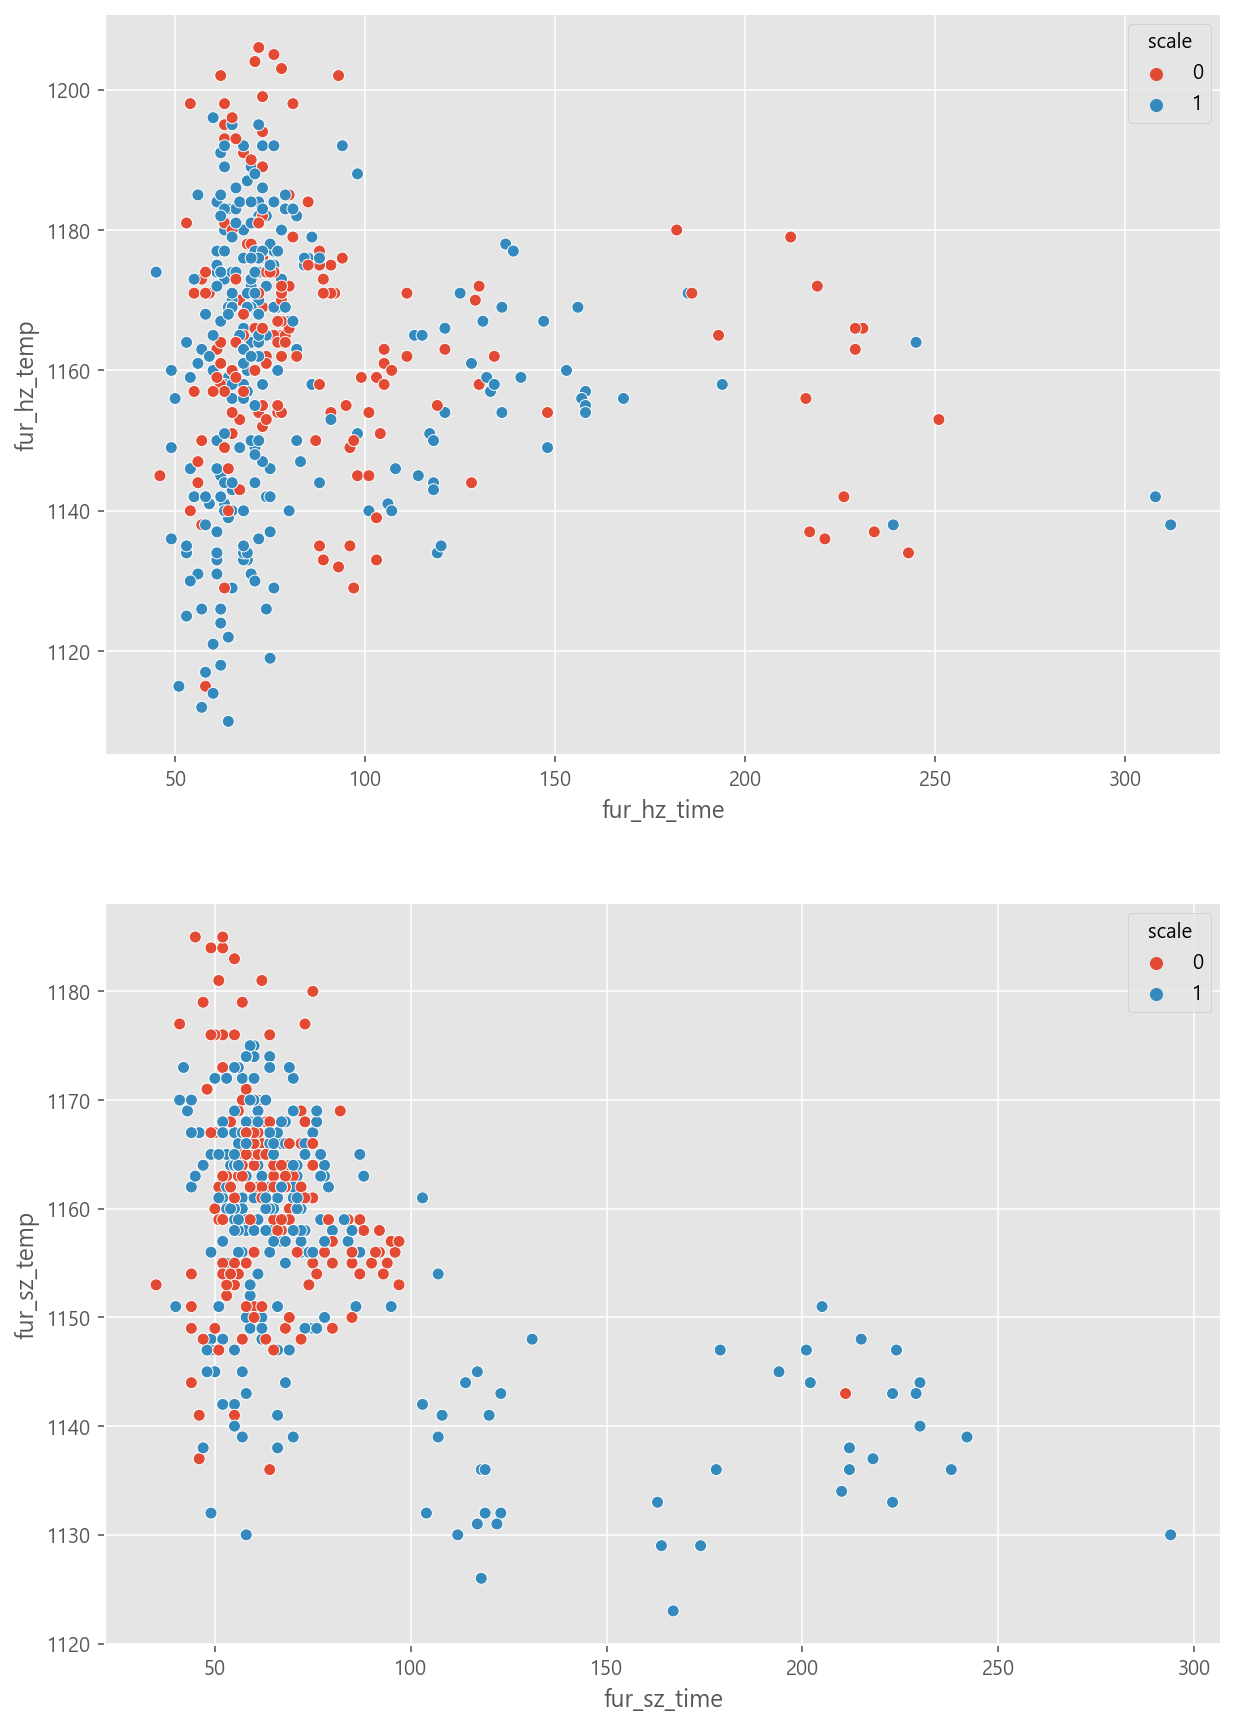

In [35]:
fig_02 = plt.figure(figsize=(10,15))
ax1 = fig_02.add_subplot(2,1,1)
ax2 = fig_02.add_subplot(2,1,2)

sns.scatterplot(data=main_02, x='fur_hz_time', y='fur_hz_temp', hue = 'scale', ax=ax1)
sns.scatterplot(data=main_02, x='fur_sz_time', y='fur_sz_temp', hue = 'scale', ax=ax2)


- 1번 그래프를 통해 fur hz에서 175분 이상 가열하지 않고 100분 이내 가열할 때 불량율을 낮출 수 있는 방법이 필요해 보인다.
- 1번 그래프를 통해 약 1130도 이하에서 작업하는 것이 불량품을 줄일 수 있을 것으로 보인다.
- 2번 그래프를 통해 fur sz에서 100~150분 사이에서 가열하는 것이 시간적, 비용적 가장 좋을 것으로 보인다.
- 2번 그래프를 통해 약 1140도 이하에서 작업하는 것이 불량품을 줄일 수 있을 것으로 보인다.
- 3번 그래프를 위 4가지 인사이트에 대한 근거로 볼 수 있다.
- ?온도와 시간 외의 변수를 생각해야한다 / 공장 입장에서 시간을 늘리는 게 쉽지않다
- 총 가열로 시간 - (sz+hz) = 새로운 time <- 분석
- time 100을 기준으로 분석?

- 총 가열로 시간 - (sz+hz) = 새로운 time -> 새로운 변수로 정의, 새로운 변수의 가중치가 높을 것으로 가설

## 머신러닝

In [36]:
main_02['unnamed_time'] = main_02['fur_time'] - (main_02['fur_sz_time'] + main_02['fur_hz_time'])

C:\Users\mrshi\AppData\Local\Temp\ipykernel_7732\549661945.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [38]:
main_02['scale'] = main_02['scale'].astype('category')
main_02['hsb'] = main_02['hsb'].astype('category')

C:\Users\mrshi\AppData\Local\Temp\ipykernel_23228\179891520.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mrshi\AppData\Local\Temp\ipykernel_23228\179891520.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [39]:
main_03 = main_02.drop('plate_no', axis=1)
main_03.head()

,scale,spec,steel_kind,pt_thk,pt_wdth,pt_lth,pt_wgt,fur_hz_temp,fur_hz_time,fur_sz_temp,fur_sz_time,fur_time,rolling_temp_t5,hsb,rolling_descaling,unnamed_time
0,1,JS-SM490YB,C0,14.09,3284,51234,93050,1140,80,1131,117,352,915,1,10,155
1,1,JS-SM490YB,C0,14.09,3284,51234,93050,1142,74,1132,123,353,923,1,10,156
2,1,JS-SM490YB,C0,14.09,3284,51234,93050,1142,75,1131,122,353,913,1,10,156
3,1,JS-SM490YB,C0,14.09,3284,51234,93050,1143,65,1136,118,354,955,1,10,171
4,1,JS-SM490YB,C0,14.09,3284,49142,89250,1140,65,1136,119,355,955,1,10,171


In [40]:
main_03['scale']=main_03['scale'].astype('category')
main_03['hsb']=main_03['hsb'].astype('category')


In [41]:
main_03['spec']=main_03['spec'].astype('category')
main_03['steel_kind']=main_03['steel_kind'].astype('category')

In [42]:
y = main_03.loc[:, 'scale']
y

0      1
1      1
2      1
3      1
4      1
      ..
548    1
549    1
550    1
551    1
552    1
Name: scale, Length: 415, dtype: category
Categories (2, int64): [0, 1]

In [93]:
main_04 = main_03.drop('scale', axis=1)
main_04.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 0 to 552
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   spec               415 non-null    category
 1   steel_kind         415 non-null    category
 2   pt_thk             415 non-null    float64 
 3   pt_wdth            415 non-null    int64   
 4   pt_lth             415 non-null    int64   
 5   pt_wgt             415 non-null    int64   
 6   fur_hz_temp        415 non-null    int64   
 7   fur_hz_time        415 non-null    int64   
 8   fur_sz_temp        415 non-null    int64   
 9   fur_sz_time        415 non-null    int64   
 10  fur_time           415 non-null    int64   
 11  rolling_temp_t5    415 non-null    int64   
 12  hsb                415 non-null    category
 13  rolling_descaling  415 non-null    int64   
 14  unnamed_time       415 non-null    int64   
dtypes: category(3), float64(1), int64(11)
memory usage: 44.2 

Series.str.get_dummies
Convert Series to dummy codes.

from_dummies()
Convert dummy codes to categorical DataFrame.

In [94]:
main_04 = pd.get_dummies(main_04)

In [95]:
x = pd.DataFrame(main_04.iloc[:, 1:])
y = pd.DataFrame(main_03.loc[:, 'scale'])
x.columns

Index(['pt_wdth', 'pt_lth', 'pt_wgt', 'fur_hz_temp', 'fur_hz_time',
       'fur_sz_temp', 'fur_sz_time', 'fur_time', 'rolling_temp_t5',
       'rolling_descaling', 'unnamed_time', 'spec_BV-AH32', 'spec_BV-B',
       'spec_JS-SM490A', 'spec_JS-SM490YB', 'spec_JS-SS400', 'spec_KR-A',
       'spec_LR-A', 'spec_LR-AH32', 'spec_LR-B', 'spec_NK-KA32', 'spec_NV-A',
       'spec_NV-A32', 'spec_SA283-C', 'steel_kind_C0', 'hsb_0', 'hsb_1'],
      dtype='object')

pca, scaler, regression, xgboosting(regression, classify)

In [96]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

x_tn, x_ts, y_tn, y_ts = train_test_split(x, y, test_size=0.3)

ModuleNotFoundError: No module named 'xgboost'

In [97]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [98]:
std = StandardScaler()
std.fit(x_tn)

std_x_tn = std.transform(x_tn)
std_x_ts = std.transform(x_ts)

scaler = MinMaxScaler()
scaler.fit(x_tn)
scalerd_x_tn = scaler.transform(x_tn)
scalerd_x_ts = scaler.transform(x_ts)

NameError: name 'x_tn' is not defined

In [99]:

rf = RandomForestClassifier(max_depth=7, n_estimators=500)
rf.fit(std_x_tn, y_tn)

pred_rf = rf.predict(std_x_ts)

NameError: name 'RandomForestClassifier' is not defined

In [100]:
std_tn_score = rf.score(std_x_tn, y_tn)
std_ts_score = rf.score(std_x_ts, y_ts)

print('랜덤 포레스트 훈련 스코어는 {}이고 테스트 스코어는 {}입니다.'.format(std_tn_score, std_ts_score))

NameError: name 'rf' is not defined

In [101]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

conf_matrix = confusion_matrix(y_ts, pred_rf)
class_report = classification_report(y_ts, pred_rf)

NameError: name 'y_ts' is not defined

In [102]:
print(conf_matrix)

NameError: name 'conf_matrix' is not defined

In [103]:
print(class_report)

NameError: name 'class_report' is not defined

In [104]:
importance = pd.DataFrame({'feature_name' : x.columns, 'coefficient' : rf.feature_importances_})
importance=importance.sort_values(by='coefficient', ascending=False)

NameError: name 'rf' is not defined

In [105]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(10,8))
sns.barplot(data=importance, x='coefficient',y='feature_name')

NameError: name 'importance' is not defined

<Figure size 720x576 with 0 Axes>

- 당초 설정한 unnamed time의 가중치는 유의미하지 않게 나타났고 압연 온도가 가장 영향을 많이 미치는 것으로 나타났다.

In [37]:
main_02['spec'].nunique()

13

In [38]:
ans = main_02.groupby(['scale','spec'], as_index=False)[['rolling_temp_t5']].mean()
ans


,scale,spec,rolling_temp_t5
0,0,BV-AH32,1005.000000
1,0,BV-B,1003.166667
2,0,JS-SM490A,1033.320000
3,0,JS-SM490YB,1004.914286
4,0,JS-SS400,1036.937500
5,0,KR-A,1000.294118
6,0,LR-A,991.818182
7,0,LR-AH32,965.600000
8,0,LR-B,979.166667
9,0,NK-KA32,962.000000


In [39]:
fig = px.line(ans, x='spec',y='rolling_temp_t5', color='scale', title='SPEC별 ROLLING_TEMP')
fig.data[1].line.color = "#000A3E"
fig.data[0].line.color = "#FD6F22"
fig.update_layout(plot_bgcolor="#E5E5E5")
fig.update_layout(
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    title_font_size=25
)
newnames = {'0':'불량', '1': '양품'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))
# fig.write_image("six_project_line.png")